In [1]:
import math
import optuna
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import (StratifiedKFold,
train_test_split, cross_val_score)
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier, 
                              StackingClassifier, BaggingClassifier,VotingClassifier)
from sklearn.metrics import accuracy_score, f1_score, auc

from sklearn.preprocessing import MinMaxScaler, StandardScaler,PowerTransformer

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv', index_col='id')
sub  = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')
org_data = pd.read_csv('/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv')

In [4]:
test_data_id=pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
test_ids=test_data_id['id']

In [5]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of test data : {test.shape}')

Shape of train data: (2190, 12)
Shape of test data : (730, 11)


In [6]:
org_data.columns=[col.strip() for col in org_data.columns]
org_data['rainfall']=org_data['rainfall'].map({'yes':1, 'no':0})
org_data.dropna(inplace=True)

train_df = pd.concat([train, org_data], axis=0, ignore_index=True)
test_df = test.copy()
test_df.fillna(test_df.median(), inplace=True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temparature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


In [8]:
train_df.describe().T\
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
.background_gradient(subset=['std'], cmap='Blues')\
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
day,2555.000000,156.495108,113.131808,1.000000,44.500000,148.000000,255.000000,365.000000
pressure,2555.000000,1013.625362,5.768099,998.500000,1008.600000,1013.000000,1017.800000,1034.600000
maxtemp,2555.000000,26.338708,5.701105,7.100000,21.300000,27.800000,31.200000,36.300000
temparature,2555.000000,23.921918,5.282829,4.900000,19.300000,25.500000,28.400000,32.400000
mintemp,2555.000000,22.128885,5.139142,3.100000,17.600000,23.800000,26.500000,30.000000
dewpoint,2555.000000,20.385832,5.396821,-0.400000,16.800000,22.100000,25.000000,26.700000
humidity,2555.000000,81.768689,8.187895,36.000000,77.000000,81.000000,87.000000,98.000000
cloud,2555.000000,75.062622,18.681667,0.000000,68.000000,83.000000,88.000000,100.000000
sunshine,2555.000000,3.840039,3.679170,0.000000,0.400000,2.400000,7.000000,12.100000
winddirection,2555.000000,104.383679,80.242979,10.000000,40.000000,70.000000,200.000000,350.000000


# Analysis

In [9]:
num_cols=['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection','windspeed']
target_col='rainfall'

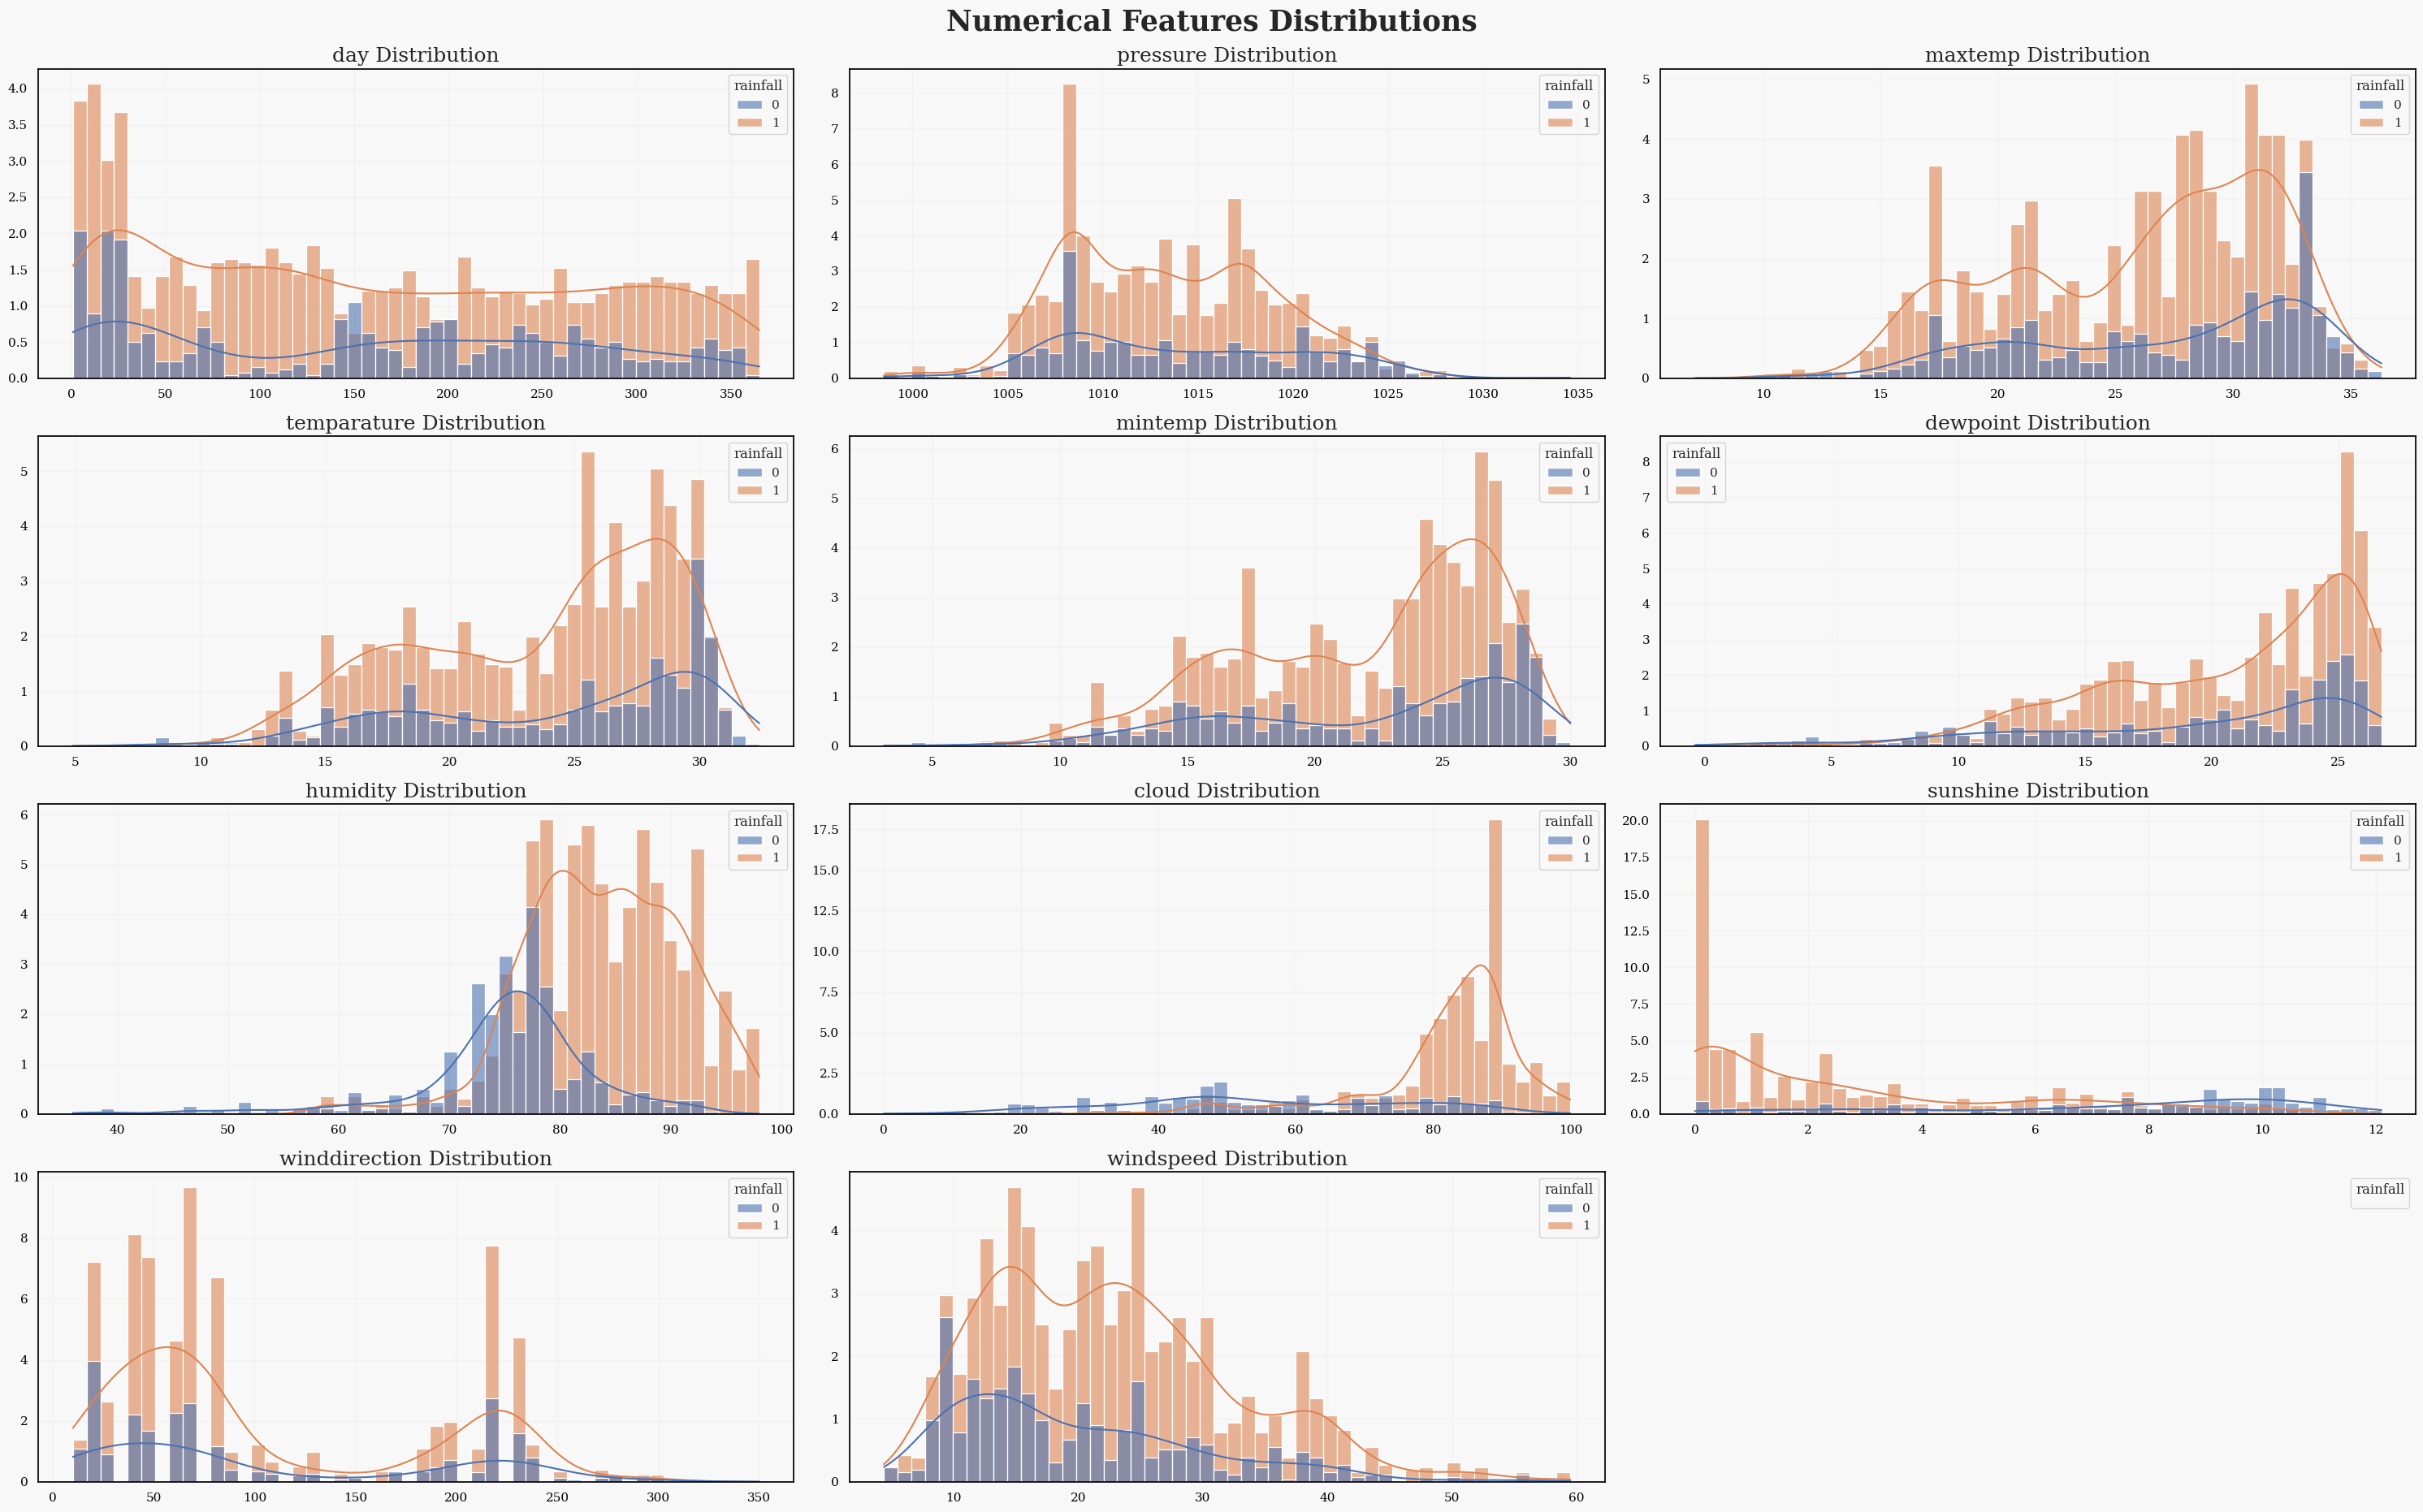

In [10]:
BINS=50
COLS=3
ROWS=math.ceil(len(num_cols)/COLS)

histplot_hyperparams={'kde':True, 'alpha':0.6,'stat' : 'percent','bins' : BINS}

fig, ax = plt.subplots(ROWS, COLS, figsize=(30, 20))
ax=ax.ravel()

for i, column in enumerate(num_cols):
    plot_axes=[ax[i]]
    sns.histplot(train_df, x=column, hue=target_col, ax=ax[i], color=palette[1], **histplot_hyperparams)
    ax[i].set_title(f'{column} Distribution', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)  
    ax[i].set_ylabel(None, fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, title=target_col)

for i in range(i + 1, len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Numerical Features Distributions\n\n\n', ha='center', fontweight='bold', fontsize=25, y=0.93)
plt.tight_layout()
plt.show()

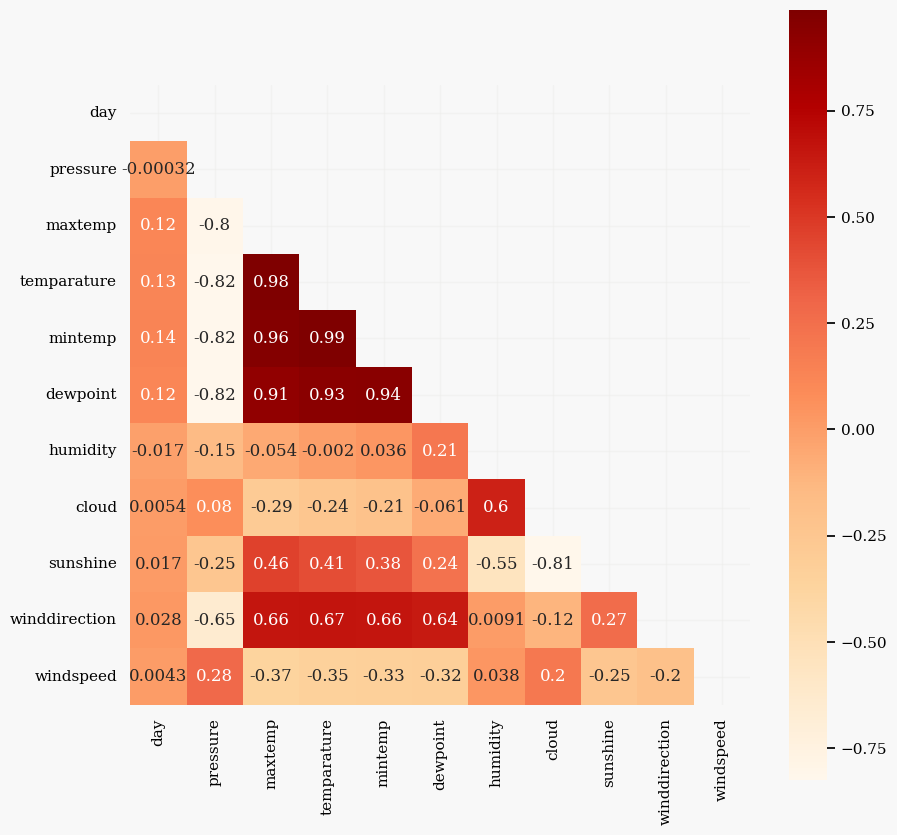

In [11]:
corr = train_df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))
plt.figure(figsize=(10, 10))

heatmap=sns.heatmap(corr, mask=mask, annot=True, square=True, cmap='OrRd')

**Key Points**
- this heatmap support the correlation that we obtained through pairplot `maxtemp`, `mintemp`, `temp`, `dewpoint` are highly correlated.
- `humidity` is positively correlated with `windspeed(62%)`, with `cloud(58%)`
- `sunshine` is positively correlated with `maxtemp(45%)`, `temp(41%)`, `mintemp(38%)`

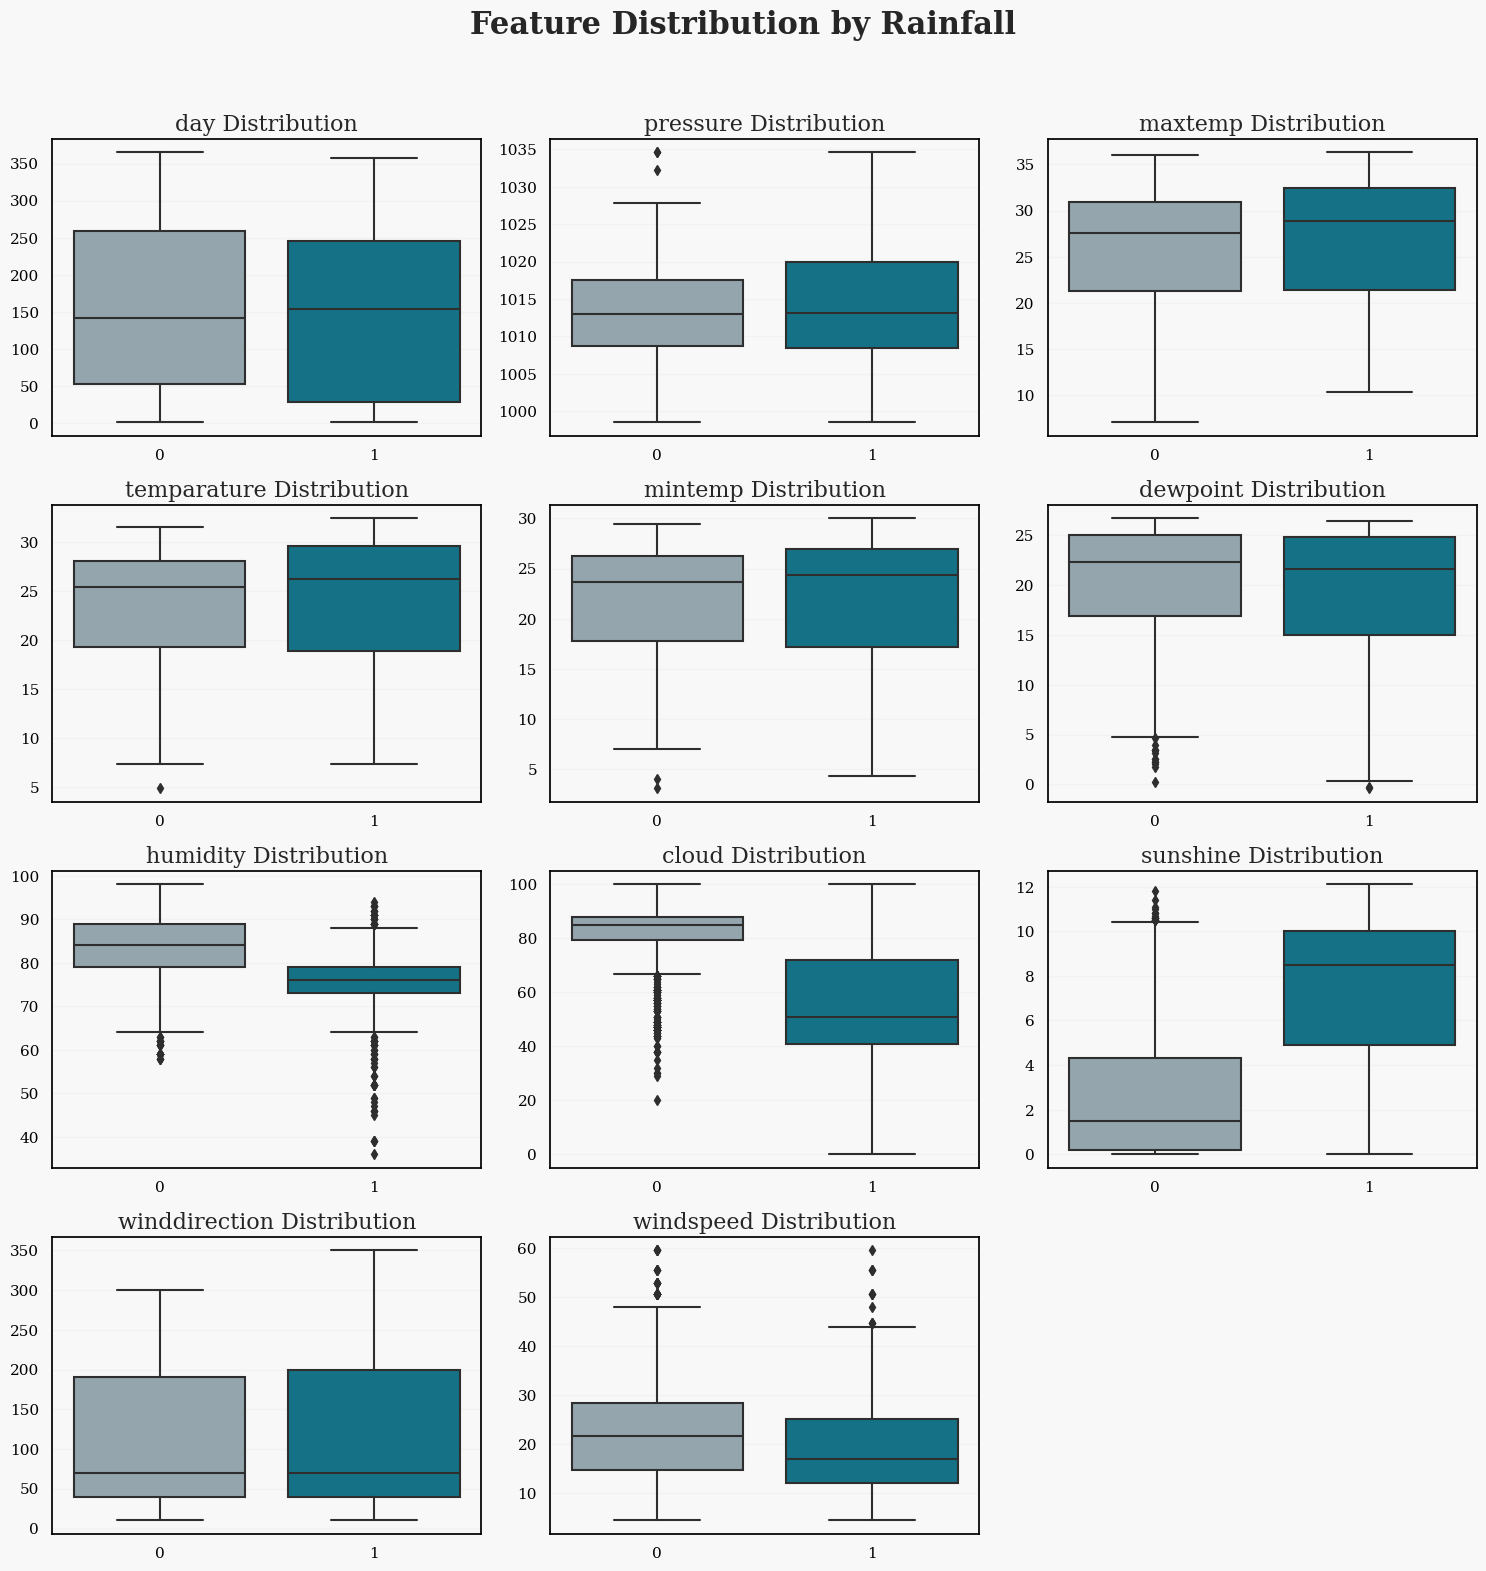

In [12]:
c = ['#90A6B1', '#037d97']
unique_target=train_df[target_col].unique()
n_categories=len(unique_target)
colors = sns.color_palette(c, n_categories)

fig, ax = plt.subplots(ROWS, COLS, figsize=(15, 4 * ROWS))
ax = ax.ravel()

for i, column in enumerate(num_cols):
    data = [train_df[train_df[target_col]==target][column] for target in unique_target]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
    ax[i].set_title(f'{column} Distribution', fontsize=16)
    ax[i].set_xlabel(None, fontsize=18)
    ax[i].set_ylabel(None, fontsize=18)

for i in range(len(num_cols), len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distribution by Rainfall\n\n', ha='center', fontweight='bold', fontsize=22)
plt.tight_layout(pad=1.0)
plt.show()

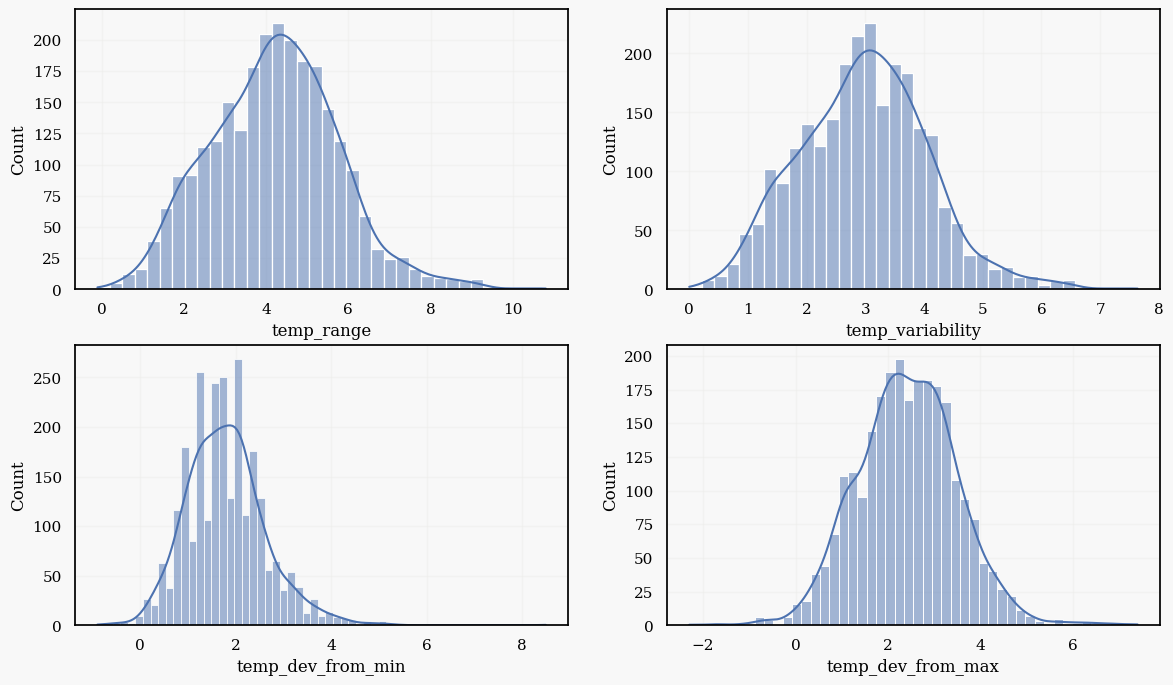

In [13]:
def new_temp_col(data):
    # data=data.copy()
    data['temp_range']=data['maxtemp']-data['mintemp']
    data['temp_variability'] =data[['maxtemp', 'mintemp']].std(axis=1)
    data['temp_dev_from_min']=data['temparature']-data['mintemp']
    data['temp_dev_from_max']=data['maxtemp'] - data['temparature']
    data['temp_avg'] = data[['maxtemp', 'temparature', 'mintemp']].mean(axis=1)
    return data

train_df = new_temp_col(train_df)
test_df  = new_temp_col(test_df)

new_temp_col=[col for col in train_df.columns if col.startswith('temp_')]

fig, ax=plt.subplots(2,2,figsize=(14,8))
ax=ax.ravel()
for i,col in enumerate(new_temp_col):
    if i>=4:
        break
    sns.histplot(data=train_df, x=col, ax=ax[i], kde=True)

- Since temparature, mintemp and maxtemp are highly related with each other that we shown through pair plot and correlation heatmap, so this feature can capture daily temperature variations.
- `temp_dev_from_min` measures how much the daily temperature deviates from the minimum temparature. higher value indicates greature temperature fluctuation, which can be helpful for understanding weather variability and similar for `temp_dev_from_max`

**Note**
- all new temp features are nearly normal which is worthable for our model building

**wind chill**
- the wind chill effect occurs because wind removes heat from the body more quickly than still air, making it feel colder than the actual temparature.
- this is standard formula used by the `meteorological services of Canada`

In [14]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0 
    elif month in [3, 4, 5]:
        return 1 
    elif month in [6, 7, 8]:
        return 2 
    else:
        return 3 

def some_other_features(data):
    data = data.copy()
    
    data['day'] = pd.to_datetime(data['day'], errors='coerce')
    data['month'] = data['day'].dt.month
    data['season']=data['month'].apply(get_season)
    data['day_of_week']=data['day'].dt.weekday
    data['is_weekend'] =data['day_of_week'].isin([5,6]).astype(int)
    
    data['season'] = data['day'].apply(get_season)
    data['day_of_year'] = data['day'].dt.dayofyear
    data['sin_day'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
    data['cos_day'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
    
    data['wind_effect']=data['windspeed']*data['winddirection']

    data['humidity_level'] = data['temparature']-data['dewpoint']
    
    data['cloud_sun_ratio'] = data['cloud']/(data['sunshine']+1)
    data['temp_humidity'] = data['temparature']*data['humidity']
    
    data['temp_humidity_interaction'] = data['temp_avg'] * data['humidity']
    data['dew_cloud_interaction'] = data['humidity_level'] * data['cloud']
    data['sun_wind_interaction'] = data['sunshine'] * data['windspeed']

    # wind direction
    data['wind_dir_rad'] = np.deg2rad(data['winddirection'])
    data['wind_dir_sin'] = np.sin(data['wind_dir_rad'])
    data['wind_dir_cos'] = np.cos(data['wind_dir_rad'])
    data.drop(columns=['wind_dir_rad'], inplace=True)

    # Rolling statistical features
    data['rolling_temp_mean'] = data['temp_avg'].rolling(window=7).mean()
    data['rolling_wind_mean'] = data['windspeed'].rolling(window=7).mean()
    data['rolling_humidity_mean']=data['humidity'].rolling(window=7).mean()

    # Lag Features
    data['temp_lag_1'] = data['temp_avg'].shift(1)
    data['humidity_lag_1'] = data['humidity'].shift(1)
    data['windspeed_lag_1'] = data['windspeed'].shift(1)

    # Wind chill factor 
    data['wind_chill'] = 13.12 + 0.6215 * data['temparature'] - 11.37 * (data['windspeed']**0.16) + 0.3965 * data['temparature'] * (data['windspeed']**0.16)
    
    return data

train_df = some_other_features(train_df)
test_df = some_other_features(test_df)



**Note**
- We dropped the columns `mintemp`, `maxtemp` and `temparature`  because they are highly correlated.
- The columns `day` and `day_of_year` were removed since the values 1 and 365 are far apart; instead, we created `sin_day` and `cos_day` to capture the cyclic nature of the data.

In [17]:
drop_cols = ['day', 'day_of_year', 'mintemp', 'maxtemp']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

test_df.fillna(test_df.mean(), inplace=True)
train_df.fillna(train_df.mean(), inplace=True)

# Model Building

In [18]:
NUMS = [col for col in test_df.columns]

for c in NUMS:
    m = train_df[c].mean()
    s = train_df[c].std()
    if s == 0 or pd.isna(s):
        train_df[c] = 0  
    else:
        train_df[c] = (train_df[c] - m) / s

    if train_df[c].dtype == 'float64':
        train_df[c] = train_df[c].astype('float32')
    if train_df[c].dtype == 'int64':
        train_df[c] = train_df[c].astype('int32')

In [19]:
for c in NUMS:
    m = test_df[c].mean()
    s = test_df[c].std()
    if s==0 or pd.isna(s):
        test_df[c]=0
    else:
        test_df[c]=(test_df[c]-m)/s

    if test_df[c].dtype=='float64':
        test_df[c] = test_df[c].astype('float32')
    if test_df[c].dtype=='int64':
        test_df[c] = test_df[c].astype('int32')

In [20]:
X = train_df.drop(columns=['rainfall'], axis=1)
y = train_df['rainfall']

In [21]:
from sklearn.model_selection import TimeSeriesSplit
def purged_cross_validation(X, y, n_splits=5, purge_length=1):
    ts_split = TimeSeriesSplit(n_splits=n_splits)
    
    for train_idx, val_idx in ts_split.split(X):
        val_idx = val_idx[val_idx >= train_idx[-purge_length]]
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        yield X_train, X_val, y_train, y_val

In [23]:
catboost_params: {'iterations': 340, 'depth': 4, 'learning_rate': 0.019981386628806455, 'l2_leaf_reg': 9.769166915225368, 'border_count': 210, 'bagging_temperature': 0.9926561979833968, 'random_strength': 6.965115036491114}

In [26]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "max_depth": trial.suggest_int("max_depth", 2, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_float("max_features", 0.3, 1.0),
#         "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
#     }
    
#     clf = ExtraTreesClassifier(**params, random_state=42, n_jobs=-1)
#     scores = []

#     for X_train, X_val, y_train, y_val in purged_cross_validation(X, y, n_splits=5, purge_length=1):
#         clf.fit(X_train, y_train)
#         preds = clf.predict(X_val)
#         scores.append(accuracy_score(y_val, preds))

#     return np.mean(scores)

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# print("Best Hyperparameters:", study.best_params)


[I 2025-03-07 05:37:50,091] A new study created in memory with name: no-name-fbca5d4b-8bb2-4906-a410-0e8f57720b55


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-07 05:37:55,878] Trial 0 finished with value: 0.8654117647058823 and parameters: {'n_estimators': 350, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 0.8824316802999881, 'bootstrap': False}. Best is trial 0 with value: 0.8654117647058823.
[I 2025-03-07 05:37:57,191] Trial 1 finished with value: 0.8663529411764704 and parameters: {'n_estimators': 63, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.7011736509273451, 'bootstrap': True}. Best is trial 1 with value: 0.8663529411764704.
[I 2025-03-07 05:38:04,091] Trial 2 finished with value: 0.8658823529411764 and parameters: {'n_estimators': 449, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 0.957259596686284, 'bootstrap': False}. Best is trial 1 with value: 0.8663529411764704.
[I 2025-03-07 05:38:10,528] Trial 3 finished with value: 0.8668235294117647 and parameters: {'n_estimators': 461, 'max_depth': 9, 'min_samples_split': 2, 

In [27]:
extra_tree_params={'n_estimators': 415, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.4240013177866302, 'bootstrap': False}

In [28]:
# Model training and evaluation
from sklearn.metrics import roc_curve, f1_score,accuracy_score
models = {"Extra Trees Classifier": ExtraTreesClassifier(**extra_tree_params)}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    auc_scores = []
    
    for X_train, X_val, y_train, y_val in purged_cross_validation(X, y):
        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        val_proba = model.predict_proba(X_val)[:, 1]
        
        accuracy = accuracy_score(y_val, val_preds)
        f1 = f1_score(y_val, val_preds)
        fpr, tpr, _ = roc_curve(y_val, val_proba)
        roc_auc = auc(fpr, tpr)
        
        print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, AUC: {roc_auc:.4f}")
        auc_scores.append(roc_auc)

    print(f"Average AUC for {model_name}: {np.mean(auc_scores):.4f}")
    
    # Train on full dataset and predict
    model.fit(X, y)
    test_proba = model.predict_proba(test_df)[:, 1]
    
    # Create submission
    submission = pd.DataFrame({'id': test_ids, 'target': test_proba})
    submission.to_csv('/kaggle/working/submission.csv', index=False)
    print(f"Submission file for {model_name} saved as /kaggle/working/submission.csv\n")

Training Extra Trees Classifier...
Extra Trees Classifier - Accuracy: 0.8800, F1 Score: 0.9228, AUC: 0.9032
Extra Trees Classifier - Accuracy: 0.8941, F1 Score: 0.9291, AUC: 0.9104
Extra Trees Classifier - Accuracy: 0.8706, F1 Score: 0.9147, AUC: 0.8966
Extra Trees Classifier - Accuracy: 0.8588, F1 Score: 0.9118, AUC: 0.8814
Extra Trees Classifier - Accuracy: 0.8424, F1 Score: 0.8900, AUC: 0.8838
Average AUC for Extra Trees Classifier: 0.8951
Submission file for Extra Trees Classifier saved as /kaggle/working/submission.csv

